# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [1]:
!python -m pip install --user --upgrade pip
!pip install tqdm
!pip install xgboost
!pip install lightgbm

Requirement already up-to-date: pip in c:\users\kk\appdata\roaming\python\python36\site-packages (19.0.3)


In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2
from module_KK import *

C:\ProgramData\Anaconda3\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


# Agile분석 결과확인

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


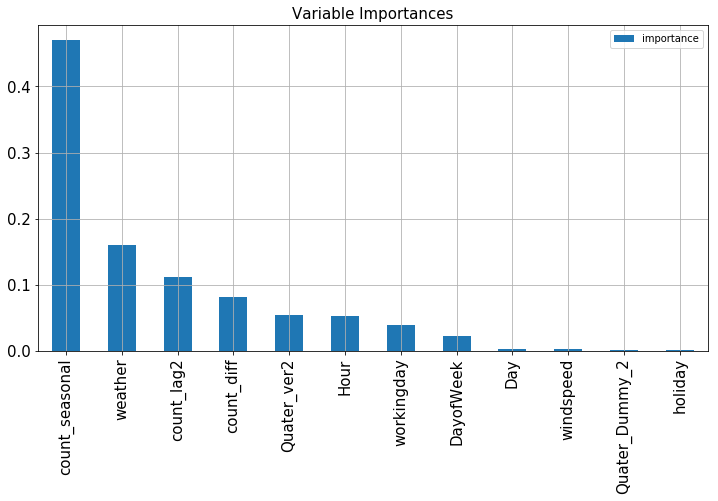

,MAE,MSE,MAPE
Train,6.54,123.38,9.11
Test,51.52,"6,749.86",40.49


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-16.29,0.83,986.65,"1,017.83","1,064.64","1,511.62",3.04
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,27.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,100.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"98,935.83",nan,nan,nan,nan,nan,NaN


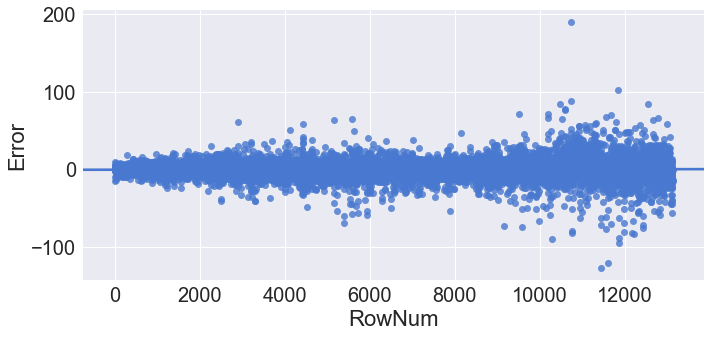

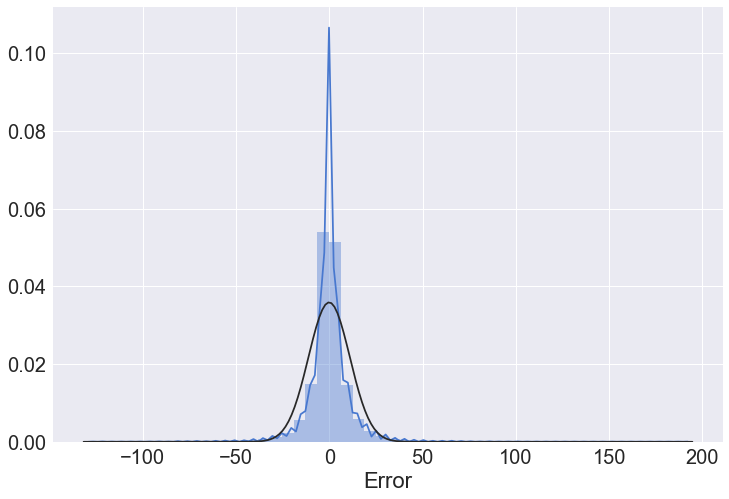

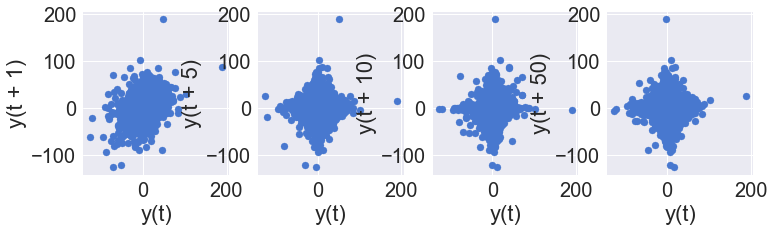

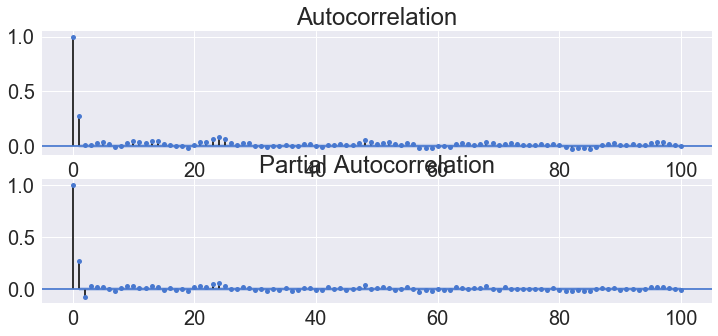

In [2]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# Applying Agile Model
# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train_feRSM)
pred_te_reg6_feRSM = fit_reg6.predict(X_test_feRSM)

# Prediction Effect of Variables
Variable_Importances = pd.DataFrame([fit_reg6.feature_importances_], 
                                    columns=X_train_feRSM.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)
plt.grid()
plt.show()

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

# Error Analysis
error_analysis(Resid_tr_reg6_feRSM, ['Error'], X_train_feRSM, graph_on=True)

# Applying Time Series Model: Y예측을 위한 TS분석 실행

Test Statistics         -6.84
p-value                  0.00
Used Lag                41.00
Used Observations   13,086.00
dtype: float64

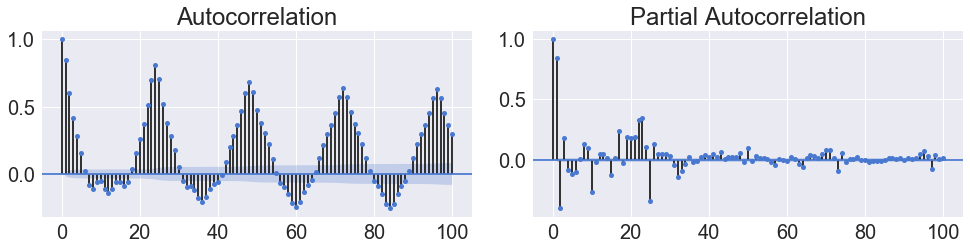

In [3]:
## 정상성 테스트 및 모수추론(p=1, q=1, d=0, P=1, Q=1, D(m)=12)
result = pd.Series(sm.tsa.stattools.adfuller(Y_train_feR.values.flatten())[0:4],
                   index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
display(result)

plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                13128
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood              -73905.064
Date:                            Fri, 05 Apr 2019   AIC                         147820.128
Time:                                    22:27:19   BIC                         147857.540
Sample:                                01-01-2011   HQIC                        147832.622
                                     - 06-30-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     58.2022      2.610     22.302      0.000      53.087      63.317
ar.L1          0.8248      0.004    187.259      0.000       0.816       0.833
ar.S.L12      -0.9998      0.000  -5396.831      0.000      -1.000      -0.999
ma.S.L12       0.9809      0.002    637.224      0.000       0.978       0.984
sigma2      4529.9751     44.224    102.432      0.000    4443.297    4616.653
===================================================================================
Ljung-Box (Q):                    14342.83   Jarque-Bera (JB):              5597.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,MAE,MSE,MAPE
Train,47.80,"4,534.02",126.01
Test,126.11,"31,707.19",140.88


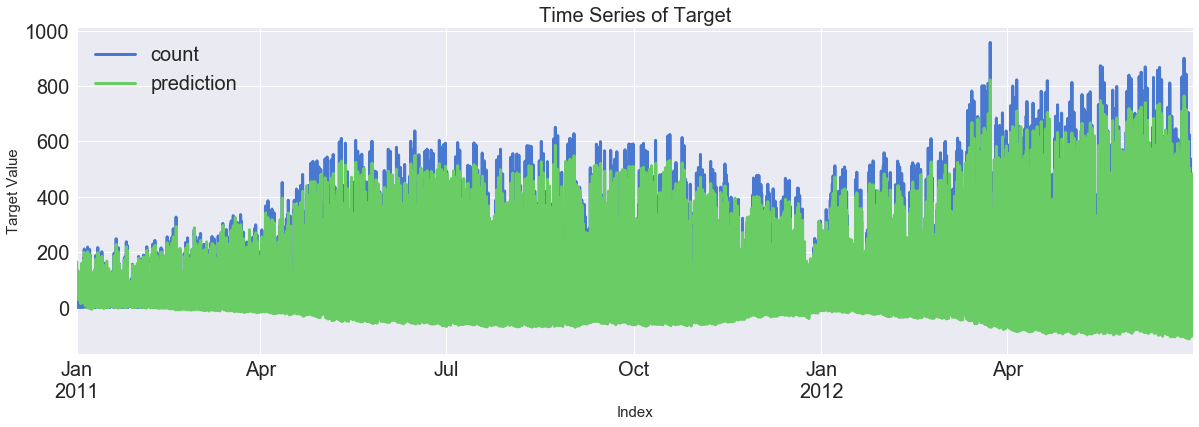

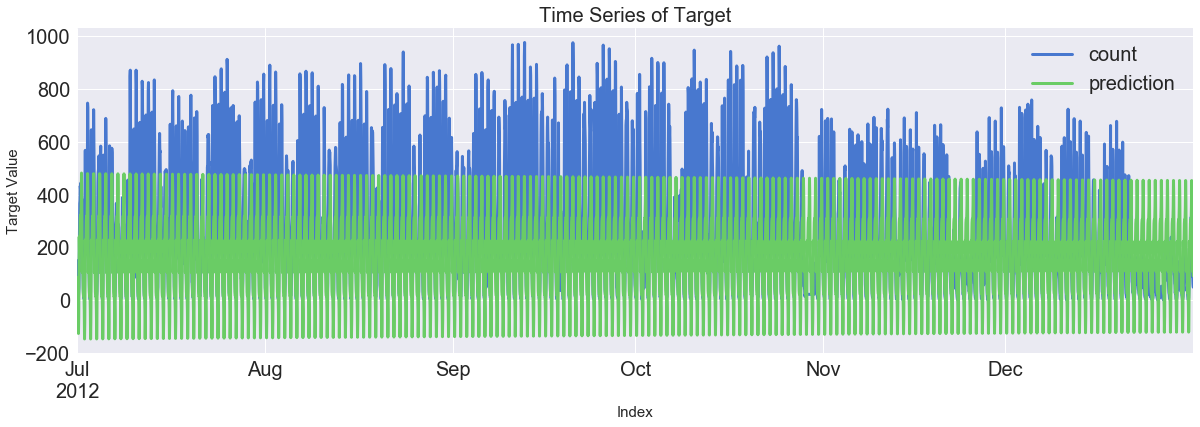

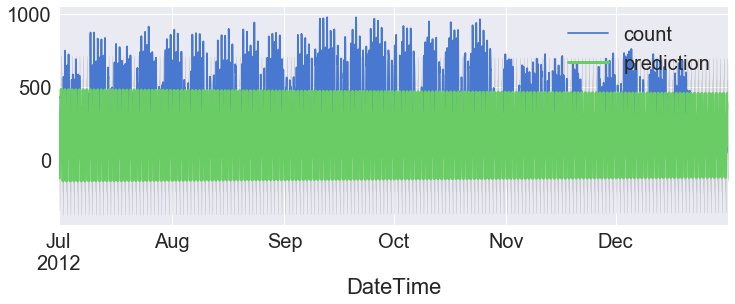

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-7.68,0.95,"1,105.78","1,630.45","3,733.66","15,200.47",1.63
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"139,428.43",nan,nan,nan,nan,nan,NaN


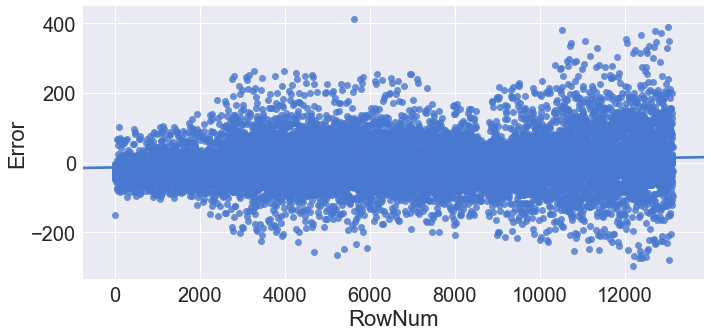

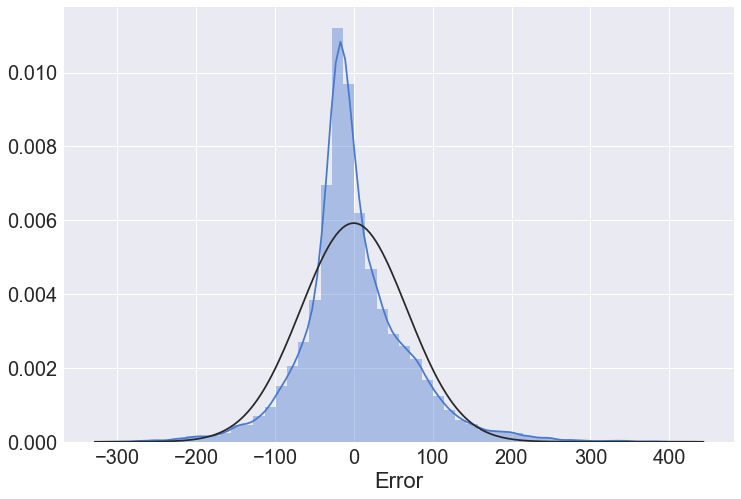

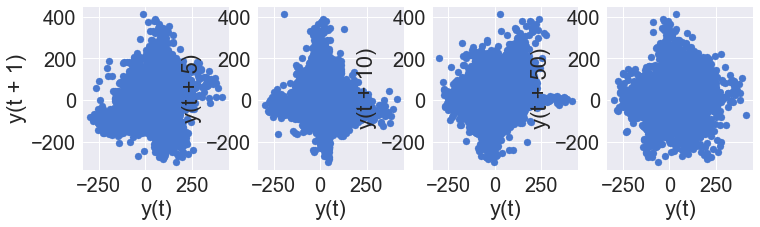

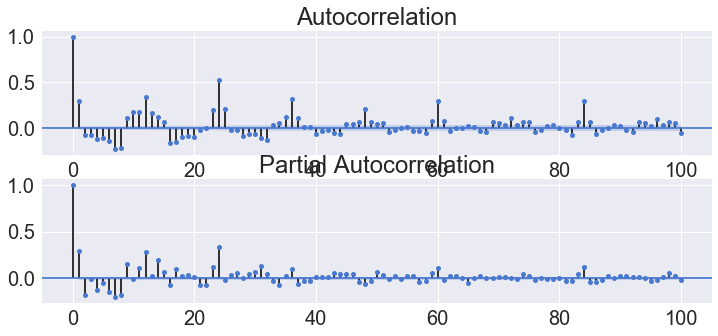

In [4]:
# 모델링
## SARIMA
logarithm, differencing = False, False
trend_diff_order, seasonal_diff_order = 0, 12
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, order=(1,trend_diff_order,0), 
                                seasonal_order=(1,0,1,seasonal_diff_order), trend='c').fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()
## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train_feR).copy()
    Y_test = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                13128
Model:             SARIMAX(1, 0, 1)x(2, 1, 2, 12)   Log Likelihood              -70623.301
Date:                            Wed, 03 Apr 2019   AIC                         141278.603
Time:                                    01:16:30   BIC                         141398.308
Sample:                                01-01-2011   HQIC                        141318.582
                                     - 06-30-2012                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.3438      0.013     27.306      0.000       0.319       0.368
count_seasonal  1378.1578     34.232     40.260      0.000    1311.065    1445.250
weather        -3.875e+04   1701.888    -22.768      0.000   -4.21e+04   -3.54e+04
count_lag2       396.6210     20.319     19.520      0.000     356.796     436.446
count_diff      1006.4558     10.360     97.149      0.000     986.151    1026.761
Quater_ver2    -6.417e+05   8671.099    -74.007      0.000   -6.59e+05   -6.25e+05
Hour           -1559.8437    644.830     -2.419      0.016   -2823.687    -296.000
workingday     -2118.5355   7142.965     -0.297      0.767   -1.61e+04    1.19e+04
DayofWeek        371.0576   1683.462      0.220      0.826   -2928.467    3670.582
ar.L1              0.5032      0.009     55.963      0.000       0.486       0.521
ma.L1              0.5187      0.009     57.868      0.000       0.501       0.536
ar.S.L12           0.0974      0.013      7.301      0.000       0.071       0.124
ar.S.L24           0.5049      0.005    100.087      0.000       0.495       0.515
ma.S.L12          -1.0484      0.015    -70.121      0.000      -1.078      -1.019
ma.S.L24           0.0496      0.015      3.330      0.001       0.020       0.079
sigma2          2732.1419     23.115    118.195      0.000    2686.836    2777.447
===================================================================================
Ljung-Box (Q):                     2921.09   Jarque-Bera (JB):             58915.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.61e+14. Standard errors may be unstable.
"""

,MAE,MSE,MAPE
Train,34.78,"2,922.32",104.68
Test,132.81,"29,356.12",271.41


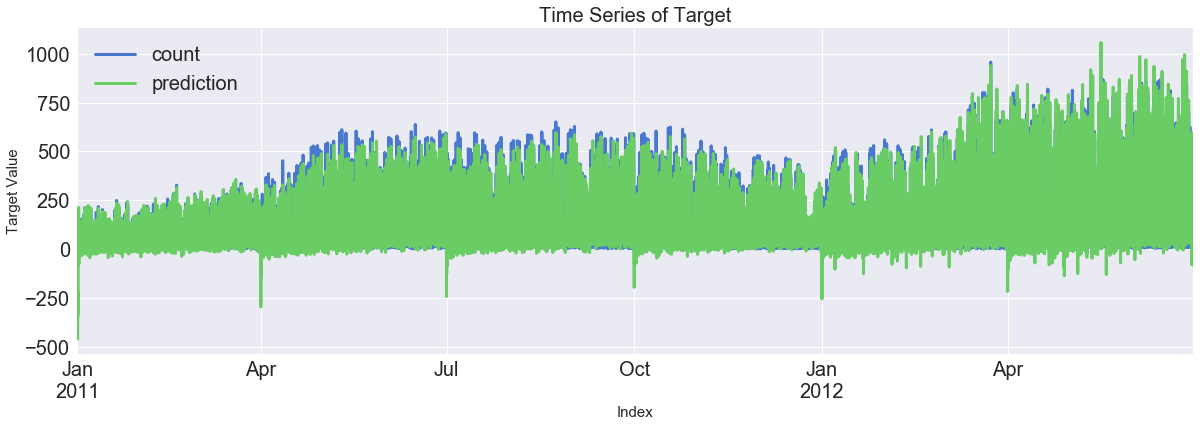

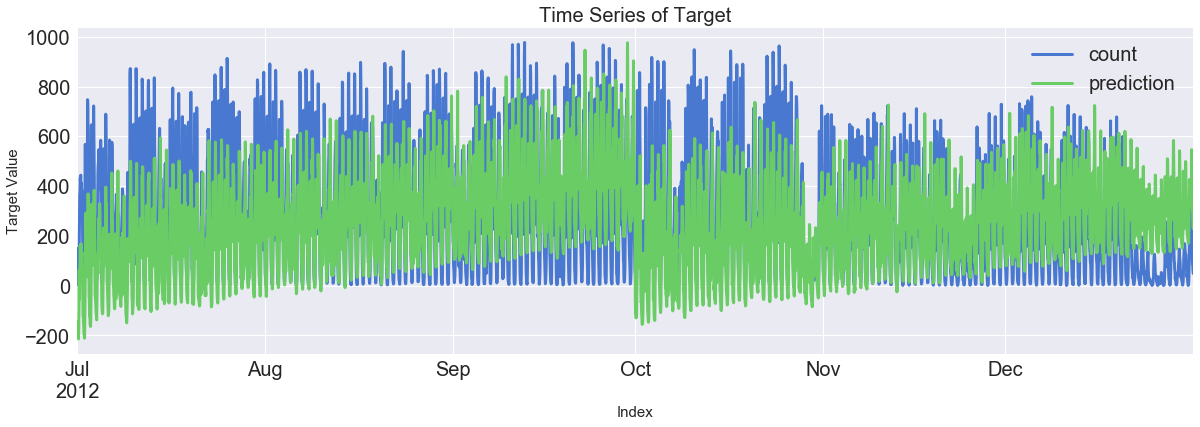

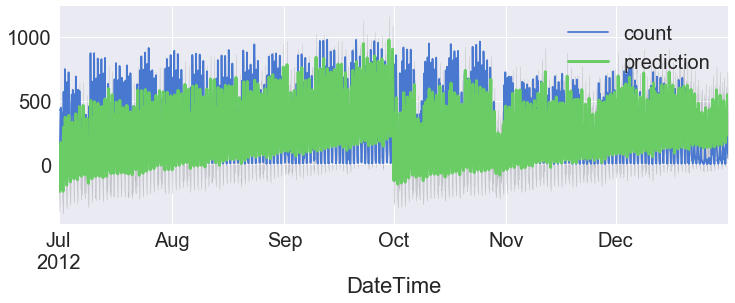

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.24,0.87,20.13,345.75,"1,385.48","3,512.45",2.44
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"138,555.77",nan,nan,nan,nan,nan,NaN


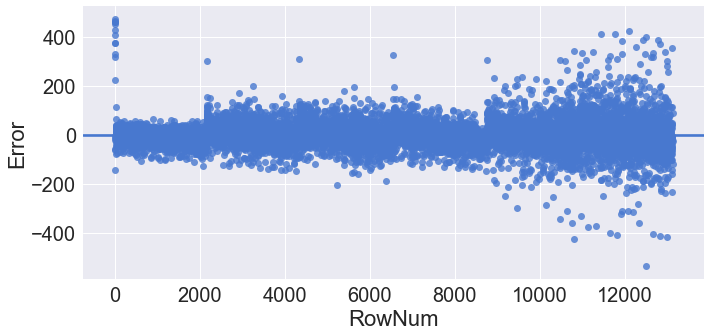

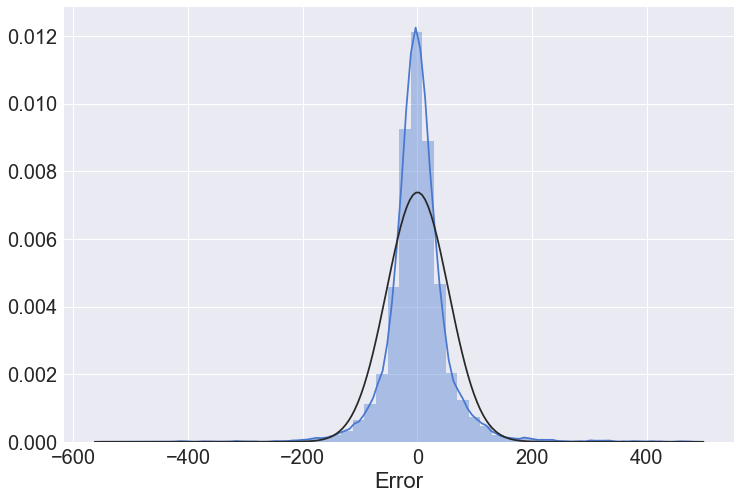

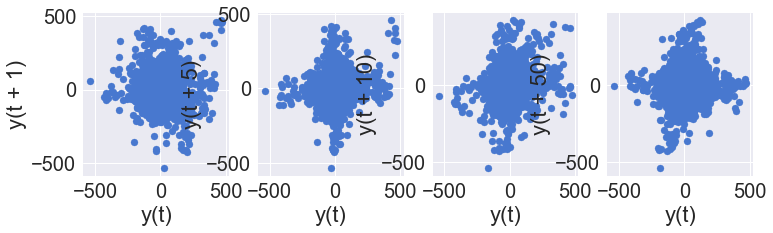

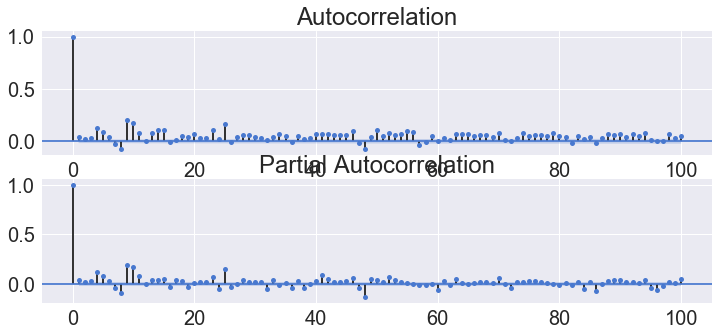

In [31]:
# 모델링
## SARIMAX
logarithm, differencing = False, False
trend_diff_order, seasonal_diff_order = 0, 12
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, exog=exog_tr, order=(1,trend_diff_order,1), 
                                seasonal_order=(2,1,2,seasonal_diff_order), trend='c').fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).conf_int()
## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train_feR).copy()
    Y_test = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=160516.375, BIC=160598.673, Fit time=21.082 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=144814.383, BIC=144911.643, Fit time=196.218 seconds


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=146482.437, BIC=146579.697, Fit time=192.884 seconds


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=155131.526, BIC=155221.305, Fit time=24.193 seconds


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=147545.134, BIC=147649.876, Fit time=198.159 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=151625.727, BIC=151715.507, Fit time=93.039 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=143181.374, BIC=143286.117, Fit time=203.906 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=142689.752, BIC=142801.976, Fit time=248.659 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=151794.219, BIC=151898.961, Fit time=106.386 seconds


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=144820.310, BIC=144940.015, Fit time=232.830 seconds


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=142838.275, BIC=142943.017, Fit time=208.174 seconds


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 0, 12); AIC=145093.460, BIC=145213.165, Fit time=251.252 seconds
Total fit time: 1976.893 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                13128
Model:             SARIMAX(2, 0, 1)x(1, 1, 0, 12)   Log Likelihood              -71329.876
Date:                            Sat, 06 Apr 2019   AIC                         142689.752
Time:                                    00:26:59   BIC                         142801.976
Sample:                                         0   HQIC                        142727.232
                                          - 13128                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8134      2.041      0.399      0.690      -3.186       4.813
drift       8.568e-05      0.000      0.418      0.676      -0.000       0.000
x1          1378.1981     31.354     43.957      0.000    1316.746    1439.650
x2         -3.875e+04   1618.450    -23.942      0.000   -4.19e+04   -3.56e+04
x3           397.3700     18.700     21.250      0.000     360.720     434.020
x4          1007.3150     10.329     97.527      0.000     987.071    1027.559
x5         -6.417e+05     30.817  -2.08e+04      0.000   -6.42e+05   -6.42e+05
x6         -1559.8443    614.964     -2.536      0.011   -2765.152    -354.536
x7         -2118.5356    142.460    -14.871      0.000   -2397.752   -1839.319
x8           371.0579    894.028      0.415      0.678   -1381.204    2123.320
ar.L1          0.4792      0.016     30.353      0.000       0.448       0.510
ar.L2         -0.1107      0.012     -8.946      0.000      -0.135      -0.086
ma.L1          0.4498      0.015     30.026      0.000       0.420       0.479
ar.S.L12      -0.7149      0.005   -158.182      0.000      -0.724      -0.706
sigma2      3096.7460     23.730    130.498      0.000    3050.236    3143.256
===================================================================================
Ljung-Box (Q):                     1691.81   Jarque-Bera (JB):             52792.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.48   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.94e+19. Standard errors may be unstable.
"""

,MAE,MSE,MAPE
Train,36.26,"3,247.32",115.93
Test,186.00,"59,232.67",369.13


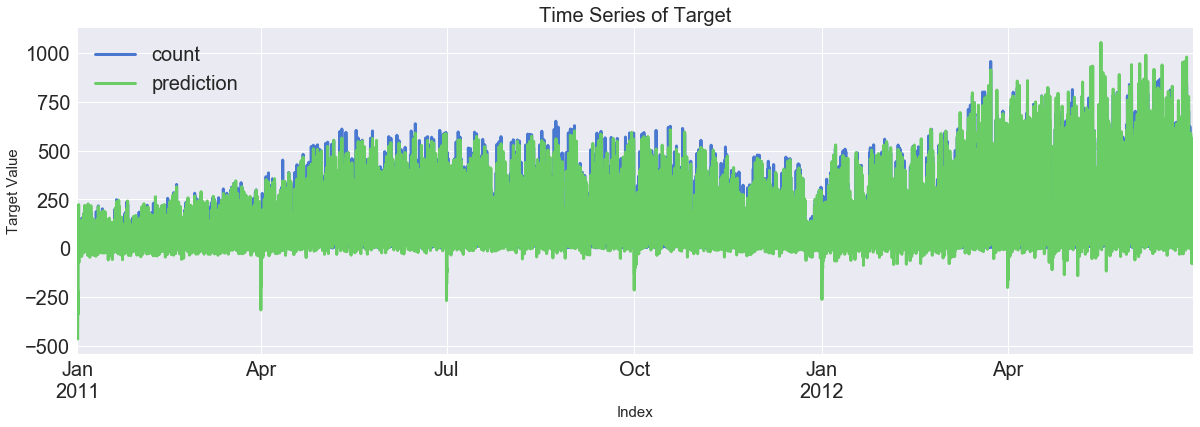

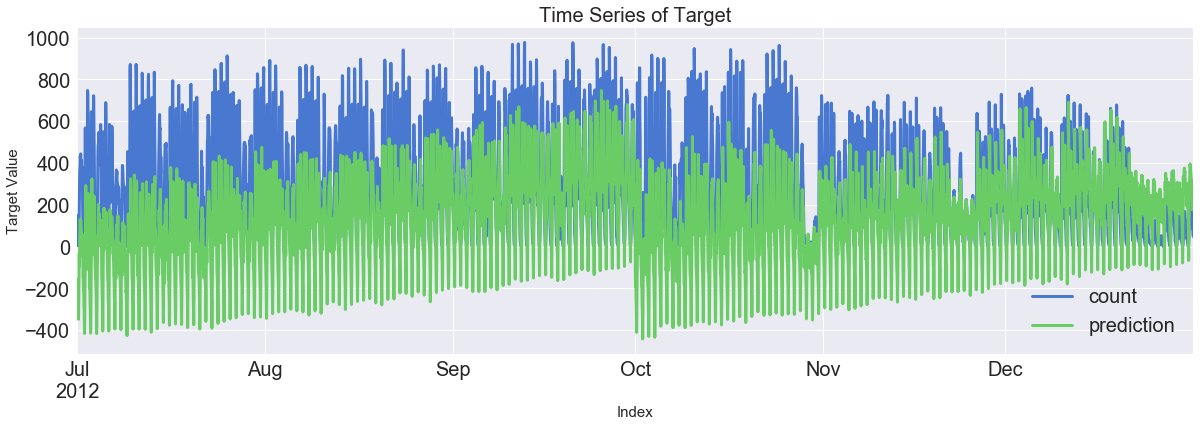

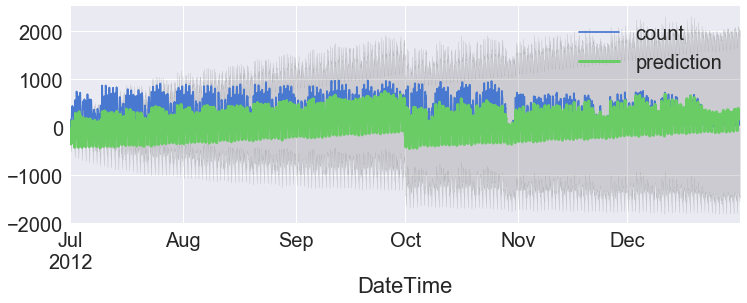

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-18.27,0.87,26.12,160.30,915.81,"2,074.58",2.48
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"140,361.68",nan,nan,nan,nan,nan,NaN


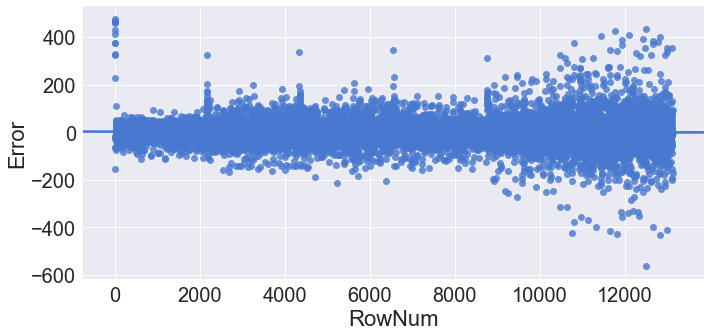

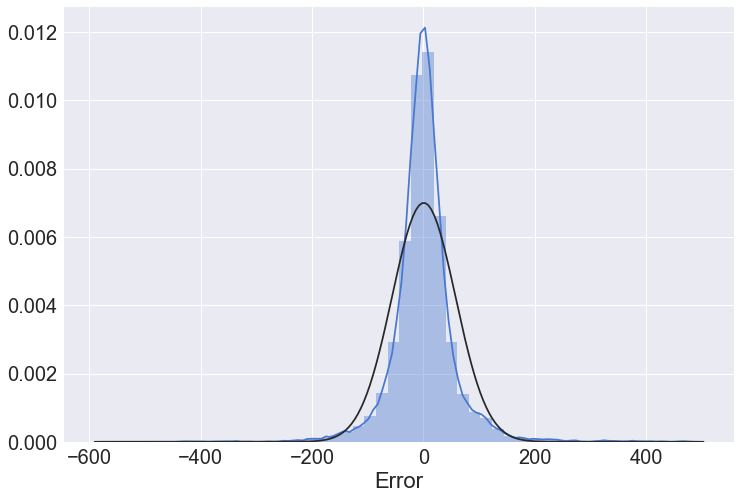

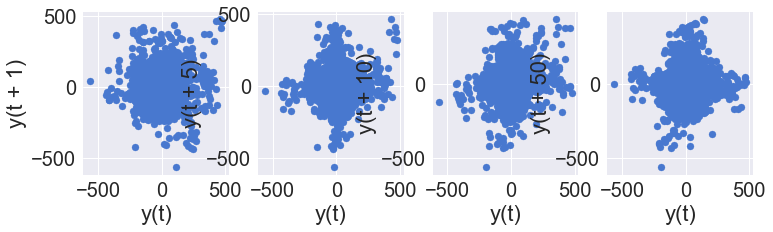

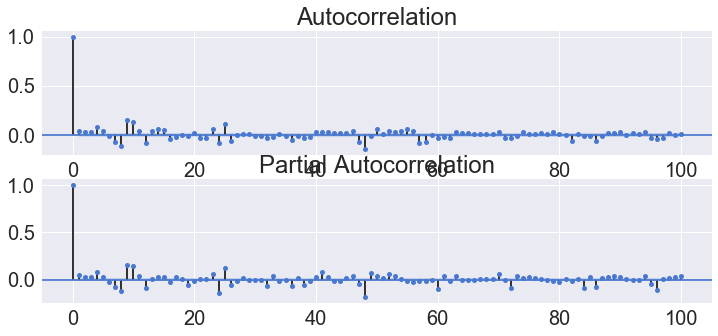

In [7]:
# 모델링
## Auto-ARIMA
logarithm, differencing = False, False
trend_diff_order, seasonal_diff_order = 0, 12
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
fit_ts_autoarima = auto_arima(Y_train_feR, exogenous=exog_tr, stationary=False,
                              trend='ct', start_p=0, start_q=0, max_p=2, max_q=2, max_d=2,
                              seasonal=True, start_P=0, start_Q=0, max_P=1, max_Q=1, m=seasonal_diff_order,
                              stepwise=True, trace=True)
display(fit_ts_autoarima.summary())
pred_tr_ts_autoarima = fit_ts_autoarima.predict_in_sample(exogenous=exog_tr)
pred_te_ts_autoarima = fit_ts_autoarima.predict(len(Y_test_feR), exogenous=exog_te, return_conf_int=True)[0]
pred_te_ts_autoarima_ci = fit_ts_autoarima.predict(len(Y_test_feR), exogenous=exog_te, return_conf_int=True)[1]
## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train).copy()
    Y_test = np.exp(Y_test).copy()
    pred_tr_ts_autoarima = np.exp(pred_tr_ts_autoarima).copy()
    pred_te_ts_autoarima = np.exp(pred_te_ts_autoarima).copy()
    pred_te_ts_autoarima_ci = np.exp(pred_te_ts_autoarima_ci).copy()
if differencing:
    pred_tr_ts_autoarima = np.cumsum(pred_tr_ts_autoarima).copy()
    
# 검증
Score_ts_autoarima, Resid_tr_ts_autoarima, Resid_te_ts_autoarima = evaluation_trte(Y_train_feR, pred_tr_ts_autoarima, 
                                                                             Y_test_feR, pred_te_ts_autoarima, graph_on=True)
display(Score_ts_autoarima)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_autoarima, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_autoarima, ['Error'], Y_train_feR, graph_on=True)
